In [1]:
%load_ext autoreload
%autoreload 2

In [151]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import robot_room as robot
from histogram_filters import plot_distribution, convolve, get_room_observation_likelihood, \
        update, run_histogram_filter, get_hist_circular_mean_var, generate_sample, plot_estimations,\
        get_walking_noise_perfect_1, get_walking_noise_example_1, plot_interactive_histogram, plot_histogram_entropy_std
import draw_hmm as hmm
from IPython import display
from IPython.display import YouTubeVideo
from scipy.stats import entropy
%matplotlib inline

In [3]:
matplotlib.__version__, np.__version__, 

('2.0.2', '1.12.1')

# Bayes filters

It is an algorithm to recursively estimate a probability distribution
over a latent state "s" (e.g. robot position) conditioned on the history of observations "o" (e.g. camera
images) and actions a (e.g. steps, velocity, etc) - (Thrun et al., 2005) 

**Latent state**: Not observable random variable (state)

This probability distribution, the posterior over the states, is called **belief**:

$P(S_i|a_1,.. ,a_n, o_1,...,o_m)$

Key assumptions:
- Markov property of the states
- Prediction step based on previous action
- Measurement step based on current measurement

# Histogram Filters
It is a type of Bayes filter that represents the belief as a histogram. It estimates the states of a system

**Main characteristics:**
- Non parametric: Full histogram (vs parametric: Gaussian distribution with mean and covariance matrix)
- Multi-modal

**Applications:**
- Google uses it to locate self-driven car

# The Robot Example. Where am I?

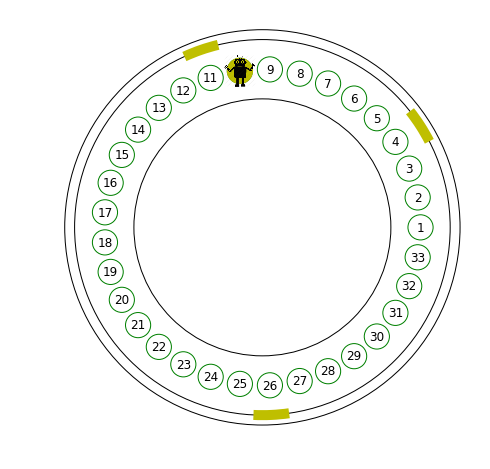

In [4]:
doors = np.array([4, 11, 26])
N = 33
robot.plot_robot_room(loc = 10, N=N, doors = doors, figsize = (8,8))

** Drawing description**
- This robot is in a circular room passage with 33 different possible positions (states). 
- There are 3 doors marked in the drawing. 
- This robot wants to find its position by sensing if there is a door in front of him

** Problem assumptions**
- The observation is noisy: The robot can sense a door when he is not really in front of a door (Low probability)
- The action of the robot is not perfect: Whenever the robot takes a step, it might take actually one, two or none

## Problem assumptions expressed in a mathematical way
### The observation/measurement step - The likelihood 
X is the random variable the robot observes and $P(X=door|S_k)$ is its distribution given that the robot is in position $S_k$

$\mathcal{L}(S_k|X=X_0)$ = $P(X=door|S_k)$ is the **likelihood**

- The likelihood is known
- The sum of the likelihood over all $S_k$ can of course be more than one
- $P(X=door|S_k) + P(X=wall|S_k) = 1$

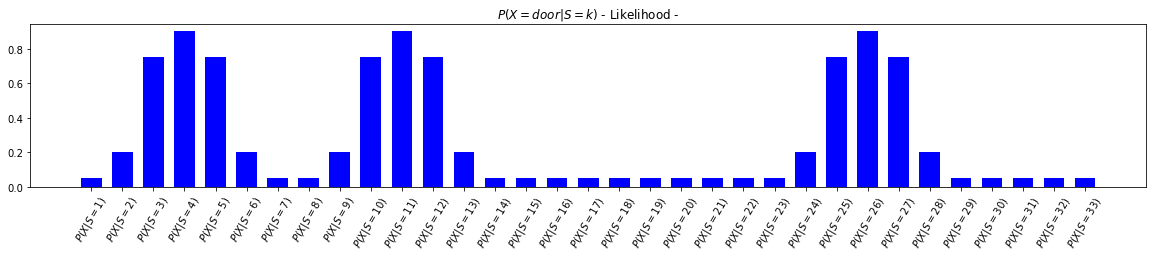

In [5]:
pulse = np.array([0.2, 0.75, 0.9, 0.75, 0.2])
noise = 0.05
str_indexes_likelihood =  ['$P(X|S=%s)$'%int(i+1) for i in range(N)]
likelihood = get_room_observation_likelihood(N = N, doors = doors, pulse = pulse, noise = noise)
plot_distribution(likelihood['door'], title = '$P(X=door|S=k)$ - Likelihood -', 
                         str_indexes= str_indexes_likelihood, rotation = 60)

https://www.youtube.com/watch?v=sm60vapz2jQ

### The prediction step - Robot action - Transition probabilities

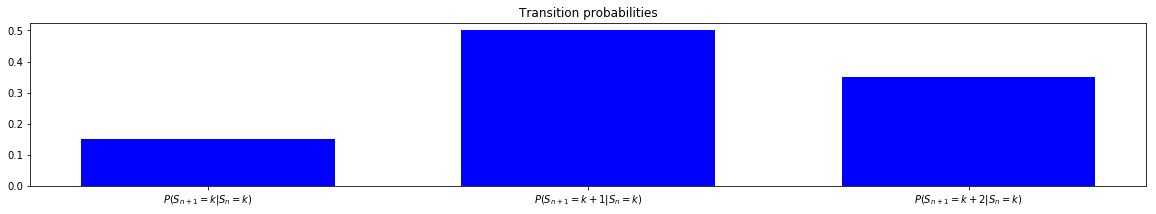

In [6]:
W = np.zeros(3)
W[0] = 0.15
W[1] = 0.50
W[2] = 0.35
str_indexes_transition =  ['$P(S_{n+1}=k|S_n=k)$', 
                           '$P(S_{n+1}=k+1|S_n=k)$', 
                           '$P(S_{n+1}=k+2|S_n=k)$']
plot_distribution(W, title = 'Transition probabilities', str_indexes= str_indexes_transition, rotation = 0)

- The transition probabilities are also known

## The model
- Histograms are discrete
- $S_k \quad k=1,...,33$ are all the possible robot positions: **The latent states**
- $S_k$ is not observable, it is a latent state. We observe $X_k$ which is correlated with $S_k$

### HMM (Hidden Markov Model)

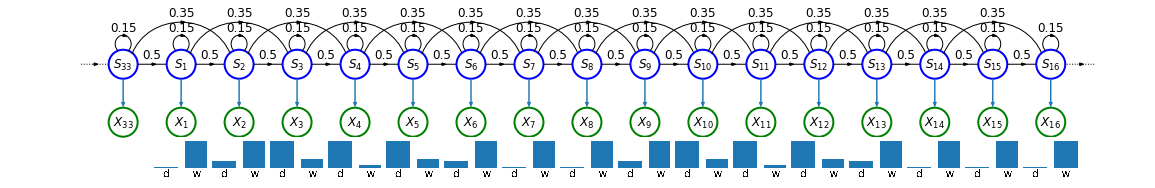

In [7]:
images_map_perfect = hmm.get_image_map_sensor(likelihood['door'])
hmm.plot_basic_hmm_model(N = N, N_states_visible = 17, circular = True, stay_step_prob = W[0], 
                         one_step_prob = W[1], two_step_prob = W[2], images_map = images_map_perfect)

In the above diagram you can see everything together:
- $X_k$: the observed variables with its likelihood
- $S_k$: the latent state variables with its transition probabilities

### The generative model

** Chose the transition probability**

In [8]:
# Original
W1 = np.zeros(3); W1[0] = 0.15; W1[1] = 0.50; W1[2] = 0.35
# Walk with steps of 3 with p=1
W2 = np.zeros(4); W2[3] = 1; 
# Walk with steps of 11 with p=1
W3 = np.zeros(12); W3[11] = 1; 
# Dont walk
W4 = np.zeros(1); W4[0] = 1; 
W_gen = W1

** Change the likelihood**

In [9]:
pulse1 = np.array([0.2, 0.75, 0.9, 0.75, 0.2])
pulse2 = np.array([0, 0, 0.9, 0, 0])
noise = 0.05


likelihood_gen = get_room_observation_likelihood(N = N, doors = doors, pulse = pulse1, noise = noise)

Theorical transition probabilities vs simulation:
Theorical: [ 0.15  0.5   0.35]
Simulation: [0.14575757575757575, 0.49606060606060604, 0.35818181818181816]


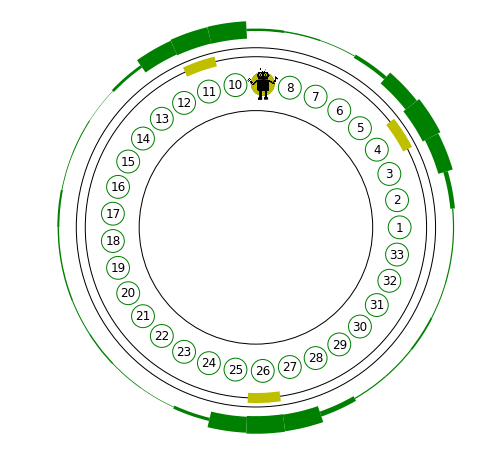

In [10]:
# Number of steps 
steps = 100*N # Change the number of steps and see how it changes
# Given the likelihood, the transition probabilities and the initial_state
measurements, sample_stats, steps_stats, loc = generate_sample(likelihood_gen, W_gen, 
                                                               initial_state = 10,
                                                               steps = steps)
print('Theorical transition probabilities vs simulation:')
print('Theorical:',W)
print('Simulation:',steps_stats)
robot.plot_robot_room(loc = loc, N=N, doors = doors, sample_stats = sample_stats)

Run it with:
- Different initial conditions
- Different steps
- Different transition probabilities
- Different likelihoods

Does the robot always finish in the same position? Why?

### The equations

** Observation step**

$X$ and $S$ are correlated

$P(X = $ "door" | $S =$ "infront door" $)$ = {{str(pulse[2])}} $\quad P(X = $ "wall" | $S =$ "infront door" $)$ = {{str(1-pulse[2])}}

$P(X = $ "door" | $S =$ "1 away from door" $)$  = {{str(pulse[1])}} $\quad P(X = $ "wall" | $S =$ "1 away from door" $)$  = {{str(1-pulse[1])}}

$P(X = $ "door" | $S =$ "2 away from door" $)$  = {{str(pulse[0])}}  $\quad P(X = $ "wall" | $S =$ "2 away from door" $)$ = {{str(1-pulse[0])}}

$P(X = $ "door" | $S =$ "other" $)$ = {{str(noise)}} $\quad P(X = $ "wall" | $S =$ "other" $)$ = {{str(noise)}}


** Prediction step**

$S_{n+1} = S_{n} + W$  (Sum of random variables)

$P(W=0) = 0.15$

$P(W=1) = 0.50$

$P(W=2) = 0.35$


# Where am I?
We are going to do the following steps to estimate the robot location:
1. Get the prior histogram 
2. Observe and estimate the posterior histogram
3. Predict new histogram after robots action
4. Go to 2

## Maximum Confusion - Prior histogram

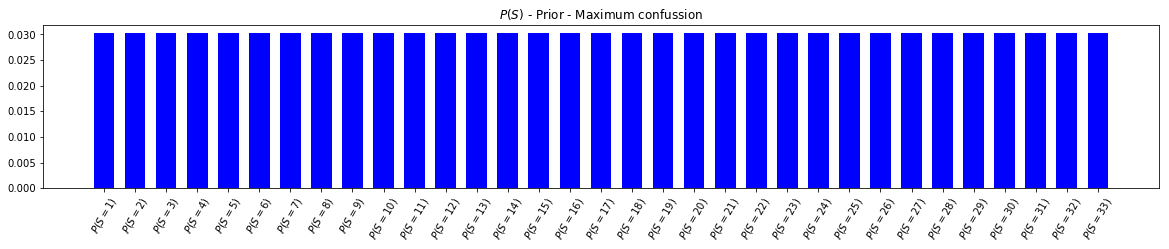

In [11]:
prior = np.ones(N)/N
str_indexes_prior =  ['$P(S=%s)$'%int(i+1) for i in range(N)]
plot_distribution(prior, title = '$P(S)$ - Prior - Maximum confussion', str_indexes= str_indexes_prior, 
                         rotation = 60)

We have no clue where we are so all the positions are equally likely

The normalized entropy is a good measure of uncertainty for multi-modal distributions

In [12]:
print("normalized entropy:",entropy(prior, base = 2)/np.log2(N))

normalized entropy: 1.0


## Observation step (Measurement) and Bayes Theorem. AKA Update

### Lets say we observe a door

We have the likelihood $P(X=door|S=k)$:

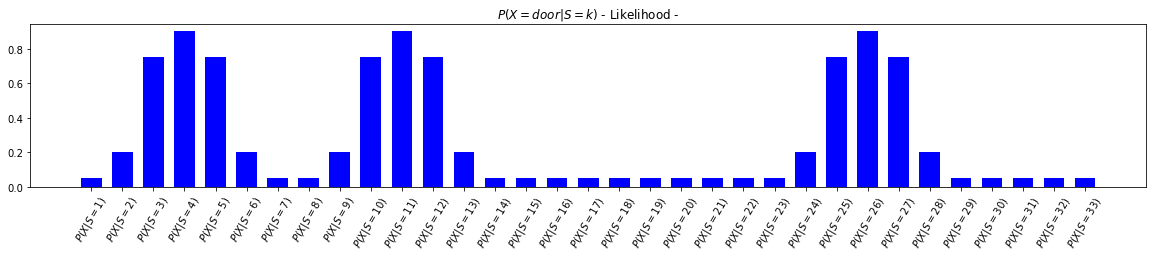

In [13]:
plot_distribution(likelihood['door'], title = '$P(X=door|S=k)$ - Likelihood -', 
                         str_indexes= str_indexes_likelihood, rotation = 60)

We need the posterior: $P(S=k|X)$

**Bayes therorem**

$P(S=k|X) = \frac{P(X|S=k)P(S=K)}{P(X)}$

$P(X) = \sum_i{P(X,S_i)} = \sum_i{P(X|S_i)P(S_i)}$

Most of the time it is not necessary to calculate P(X). We can just normalize

$P(S=k|X) = \alpha{P(X|S=k)P(S=k)}$

sum over all bins:  0.281818181818


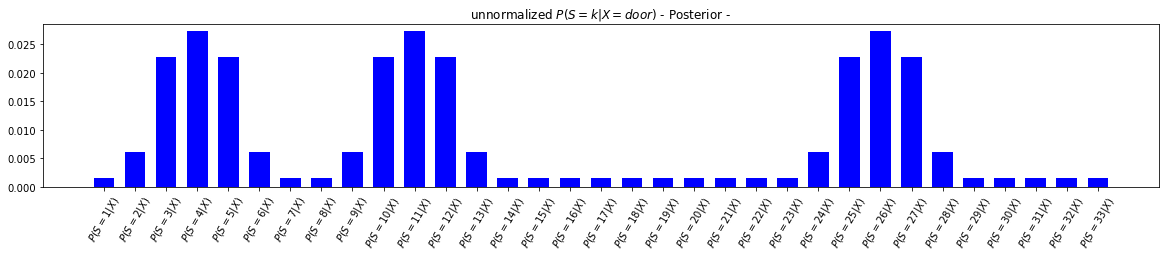

In [14]:
# We multiply prior by likelihood to get posterior
posterior_unnorm = likelihood['door']*prior

str_indexes_posterior =  ['$P(S=%s|X)$'%int(i+1) for i in range(len(prior))]
plot_distribution(posterior_unnorm, title = 'unnormalized $P(S=k|X=door)$ - Posterior -', 
                         str_indexes= str_indexes_posterior, rotation = 60)
sum_over_all = posterior_unnorm.sum()
print('sum over all bins: ',sum_over_all)

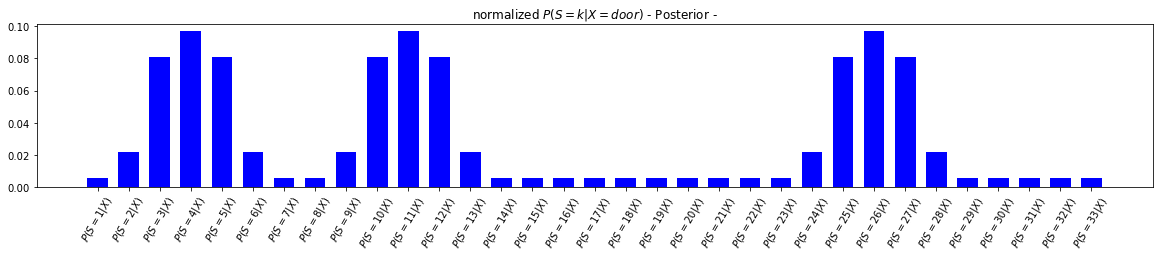

In [15]:
posterior = posterior_unnorm/sum_over_all
plot_distribution(posterior, title = 'normalized $P(S=k|X=door)$ - Posterior -', 
                         str_indexes= str_indexes_posterior, rotation = 60)

### What if we observed the wall?

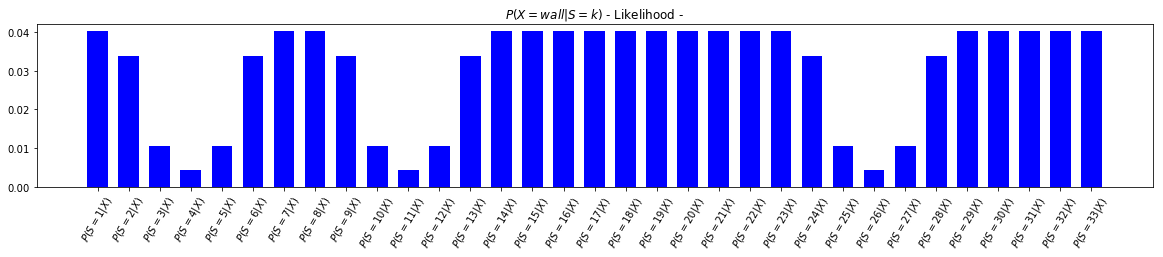

In [16]:
posterior_unnorm_wall = likelihood['wall']*prior
posterior_norm_wall = posterior_unnorm_wall/posterior_unnorm_wall.sum()
plot_distribution(posterior_norm_wall, title = '$P(X=wall|S=k)$ - Likelihood -', 
                         str_indexes= str_indexes_posterior, rotation = 60)

In [17]:
print("normalized entropy of posterior given door:",entropy(posterior, base = 2)/np.log2(N))
print("normalized entropy of posterior given wall:",entropy(posterior_norm_wall, base = 2)/np.log2(N))

normalized entropy of posterior given door: 0.828650552514
normalized entropy of posterior given wall: 0.962264345679


## Prediction step and sum of random variables (Convolution)

Lets follow the example we observed a **door** in our first observation:

$S_{n+1} = S_{n} + W$

we have the posterior $P(S_n=k|X_n = door)$ and we need to predict $P(S_{n+1}=k|X_n = door)$

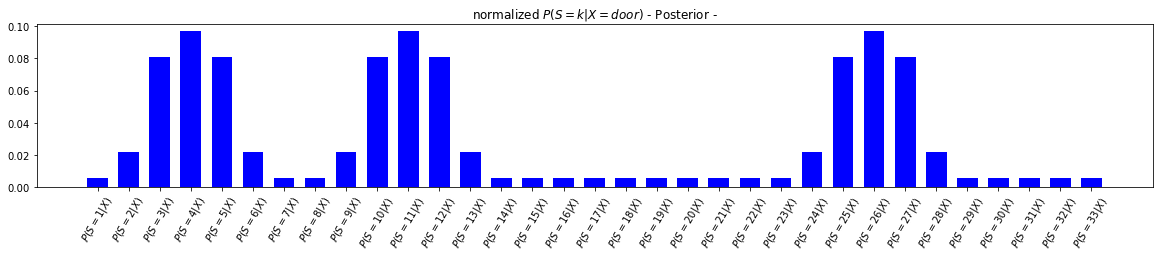

In [18]:
plot_distribution(posterior, title = 'normalized $P(S=k|X=door)$ - Posterior -', 
                         str_indexes= str_indexes_posterior, rotation = 60)

And we have the transition probabilities distribution:

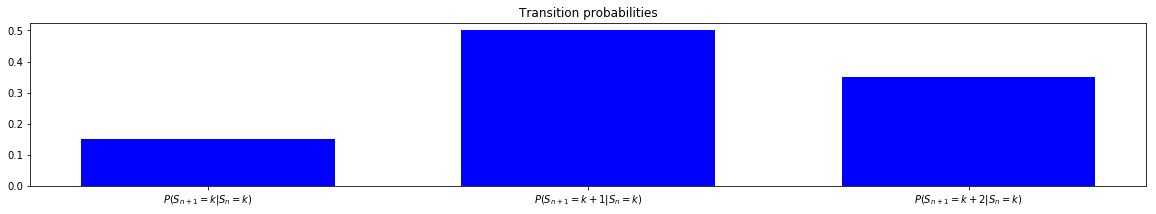

In [19]:
transition = W
plot_distribution(transition, title = 'Transition probabilities', str_indexes= str_indexes_transition, rotation = 0)

The distribution (probability mass function in this case) of the sum of two random variables is calculated as the convolution of the distributions of each variables

So doing the convolution we have:

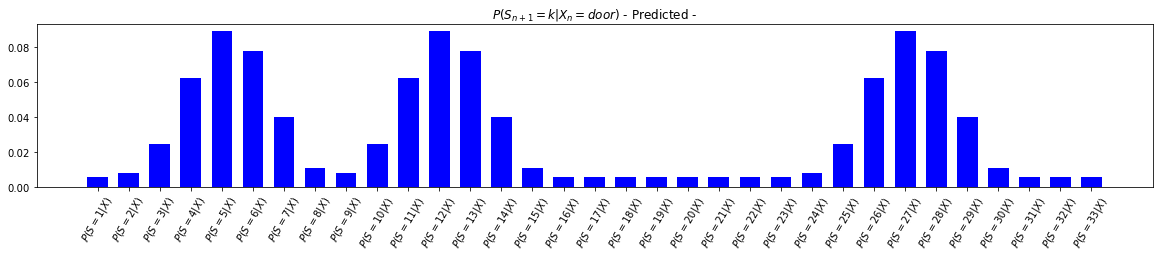

In [20]:
predicted = convolve(posterior, transition)
plot_distribution(predicted, title = '$P(S_{n+1}=k|X_n = door)$ - Predicted -', 
                         str_indexes= str_indexes_posterior, rotation = 60)

Notice that the peak is now one step ahead!

But the uncertainty had increased

In [21]:
print("normalized entropy of posterior:",entropy(posterior, base = 2)/np.log2(N))
print("normalized entropy of predicted:",entropy(predicted, base = 2)/np.log2(N))

normalized entropy of posterior: 0.828650552514
normalized entropy of predicted: 0.862888454862


## Lets observe again: we get a door!

normalized entropy of posterior_2: 0.704906880601


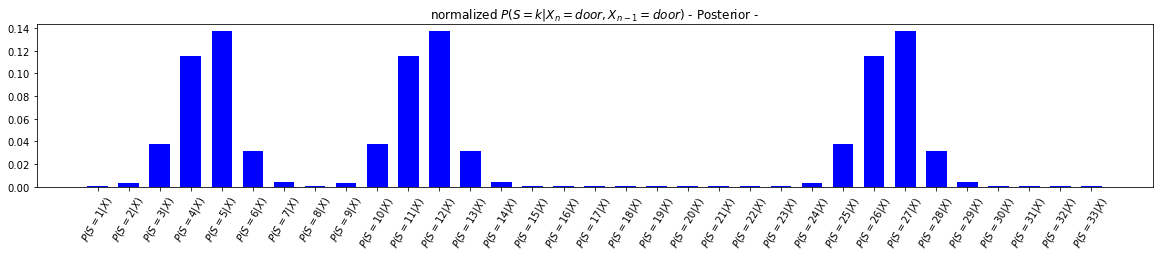

In [22]:
posterior_unnorm_2 = likelihood['door']*predicted
posterior_2 = posterior_unnorm_2/posterior_unnorm_2.sum()

plot_distribution(posterior_2, title = 'normalized $P(S=k|X_n=door, X_{n-1}=door)$ - Posterior -', 
                         str_indexes= str_indexes_posterior, rotation = 60)
print("normalized entropy of posterior_2:",entropy(posterior_2, base = 2)/np.log2(N))

## Lets predict again

normalized entropy of predicted_2: 0.76695718456


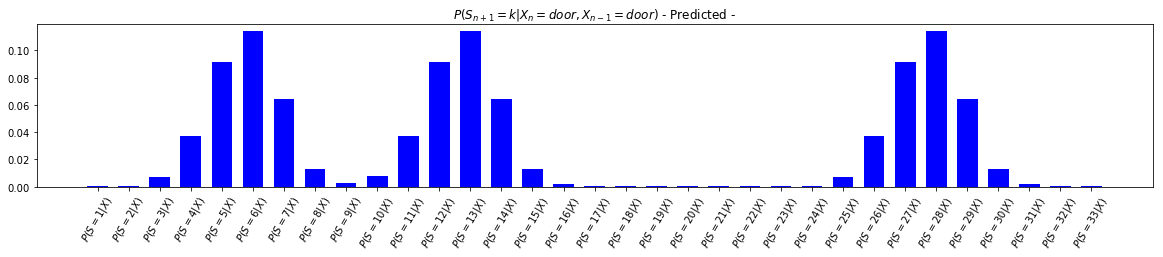

In [23]:
predicted_2 = convolve(posterior_2, transition)
plot_distribution(predicted_2, title = '$P(S_{n+1}=k|X_n=door, X_{n-1}=door)$ - Predicted -', 
                         str_indexes= str_indexes_posterior, rotation = 60)
print("normalized entropy of predicted_2:",entropy(predicted_2, base = 2)/np.log2(N))

## One more observation: But we get to see the wall {door, door, wall}

normalized entropy of posterior_3: 0.709467683369


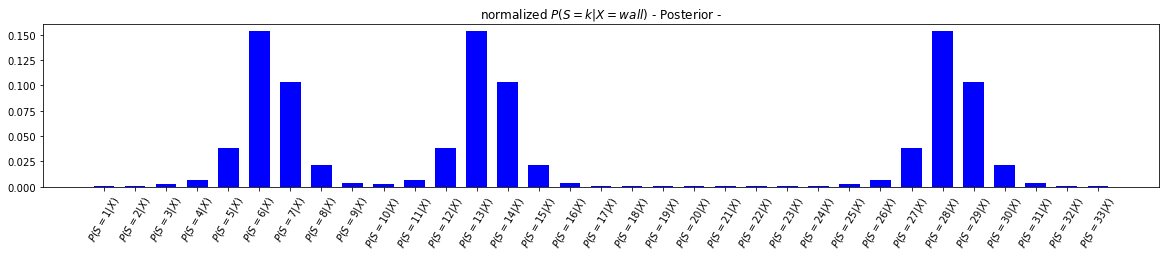

In [24]:
posterior_unnorm_3 = likelihood['wall']*predicted_2
posterior_3 = posterior_unnorm_3/posterior_unnorm_3.sum()

plot_distribution(posterior_3, title = 'normalized $P(S=k|X=wall)$ - Posterior -', 
                         str_indexes= str_indexes_posterior, rotation = 60)
print("normalized entropy of posterior_3:",entropy(posterior_3, base = 2)/np.log2(N))

The most probable is 6 because I started in 4 and took two steps. (Same for 11, and 26)

## What if I've seen 3 times doors: {door, door, door}

normalized entropy of posterior_3: 0.675024065111


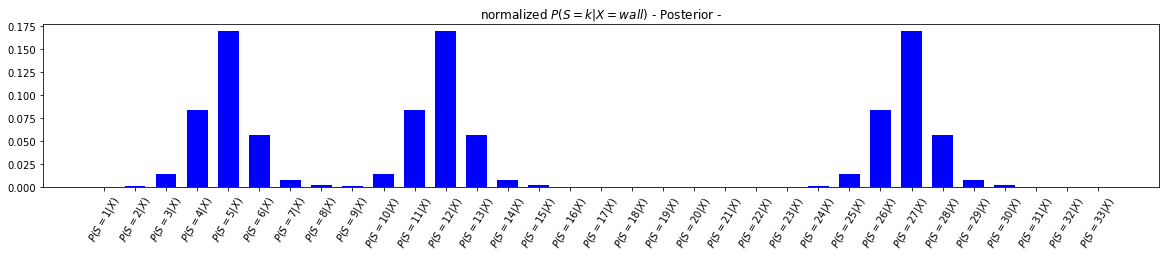

In [25]:
posterior_unnorm_3 = likelihood['door']*predicted_2
posterior_3 = posterior_unnorm_3/posterior_unnorm_3.sum()

plot_distribution(posterior_3, title = 'normalized $P(S=k|X=wall)$ - Posterior -', 
                         str_indexes= str_indexes_posterior, rotation = 60)
print("normalized entropy of posterior_3:",entropy(posterior_3, base = 2)/np.log2(N))

The most probable is 5 because I started in 3 and took two steps (Same for 10 and 25)

# The histogram filter: The complete algorithm

## The update (After observation):

In [26]:
def update(p, X, likelihood):
    # p: prior probability
    # X: Measurement. [can be door or wall in this example]
    # likelihood: It is a dict where likelihood[X] is the likelihood given observation X
    
    # posterior not normalized
    posterior = likelihood[X]*p
    # Normalize it
    normalized = posterior/posterior.sum()
    return normalized

## The prediction

In [27]:
def prediction(posterior, transition):
    # posterior: posterior probability distribution
    # transition: transition probability distribution
    return convolve(posterior, transition)

## The filter

In [171]:
def histogram_filter(W, measurements, likelihood, prior = np.ones(N)/N):
    # W: transition probability distribution
    # measurements: It is a list of observations. The i'th observation Xi = measurements[i]
    # likelihood: It is a dict where likelihood[Xi] is the likelihood given observation Xi
    # prior: The initial distribution, normaly with normalized entropy of 1 (Maximun confusion)
    normalized_entropy = []
    mean_array = []
    var_array = []
    for i in range(len(measurements)):
        posterior = update(prior, measurements[i], likelihood)
        normalized_entropy.append(entropy(posterior, base = 2)/np.log2(len(prior)))
        mean, variance = get_hist_circular_mean_var(posterior)
        mean_array.append(mean)
        var_array.append(variance)
        predicted = prediction(posterior, W)
        prior = predicted
    return posterior, predicted, normalized_entropy, mean_array, var_array

In [174]:
def plot_histogram_entropy_std(measurements, transition, likelihood, prior, n_steps = 1):
        N = len(prior)
        posterior, predicted, normalized_entropy, mean_array, var_array = histogram_filter(transition, 
                                                                    measurements[:n_steps], 
                                                                    likelihood, 
                                                                    prior = np.ones(N)/N)
        #print(measurements[:n_steps])
        f = plt.figure(figsize=(20,10))
        plt.subplot(2, 1, 1)
        plot_distribution(posterior, title = 'normalized $P(S=k|X)$ - Posterior -', fig = f)
        plt.subplot(2, 2, 3)
        plt.title("Normalized entropy")
        plt.plot(normalized_entropy)
        plt.subplot(2, 2, 4)
        plt.title("Standard deviation")
        plt.plot(np.array(var_array)**(0.5))
        plt.show()
        print("normalized entropy of last posterior:",normalized_entropy[-1])

### Example 1. Starting in first position and getting the most probable observations  and most probable steps

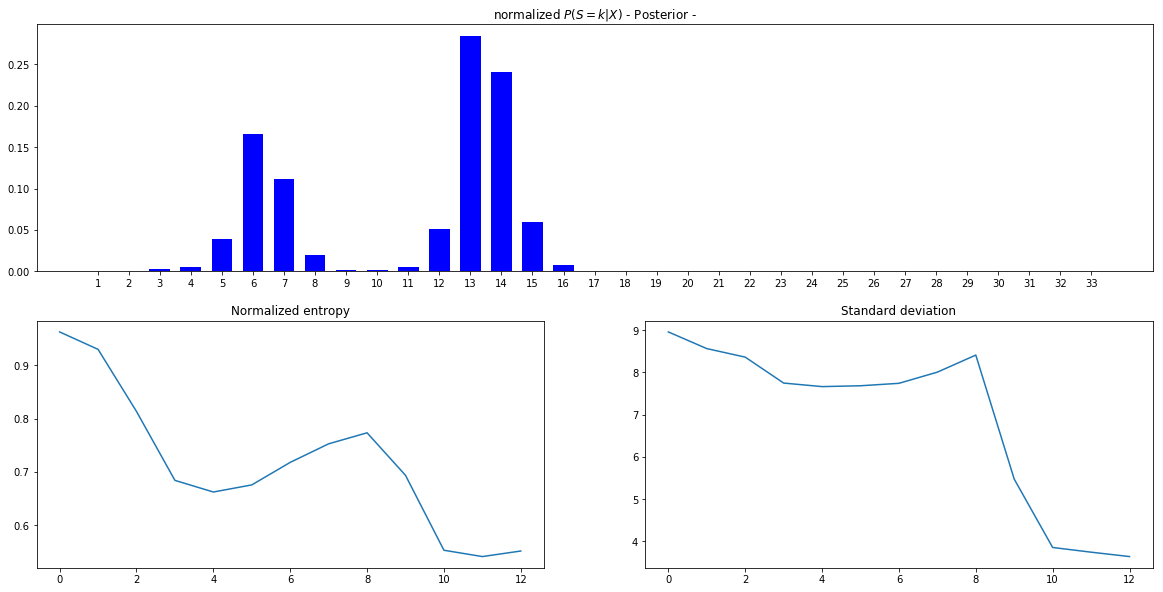

normalized entropy of last posterior: 0.551677713508


In [173]:
short_walk = ['wall', 'wall', 'door', 'door', 'door', 'wall', 'wall', 'wall', 'wall', 'door', 'door', 'door', 'wall']

plot_histogram_entropy_std(short_walk, transition, likelihood, prior, n_steps = len(short_walk))

### Example 2. A full cycle. Starting in first position and getting the most probable observations  and most probable steps

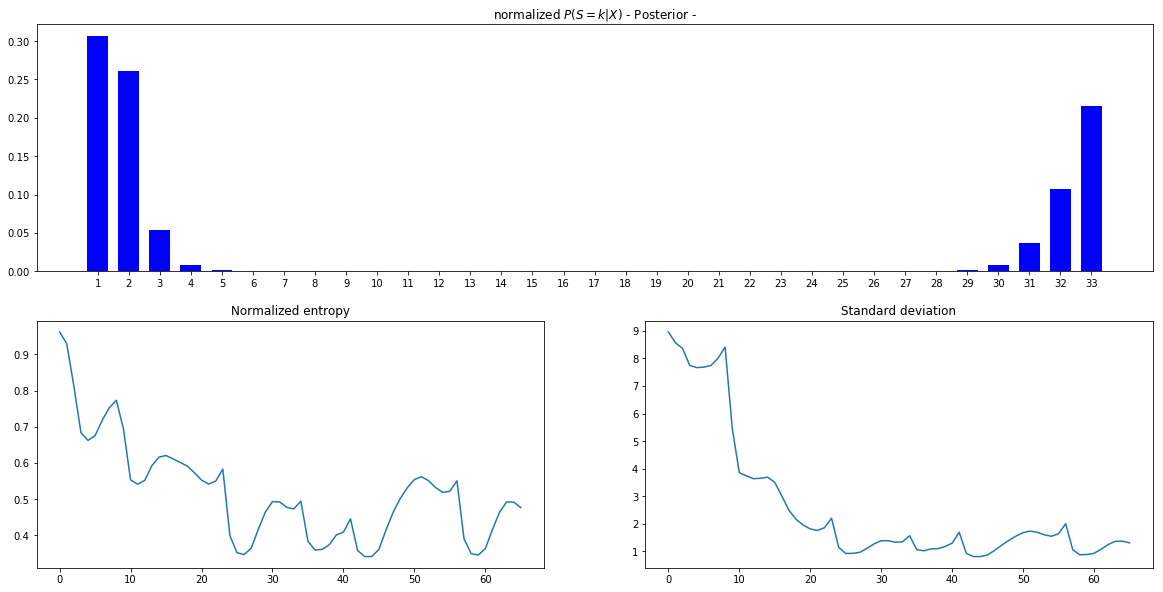

normalized entropy of last posterior: 0.47653104276


In [156]:
cicle = ['wall', 'wall', 'door', 'door', 'door', 'wall', 'wall', 'wall', 'wall', 'door', 'door', 
         'door', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 
         'wall', 'wall', 'door', 'door', 'door', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall',
         'wall', 'wall', 'door', 'door', 'door', 'wall', 'wall', 'wall', 'wall', 'door', 'door', 
         'door', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 
         'wall', 'wall', 'door', 'door', 'door', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall']

plot_histogram_entropy_std(cicle, transition, likelihood, prior, n_steps = len(cicle))


### Example 4. N full cycles. Starting in first position and getting the most probable observations and most probable steps

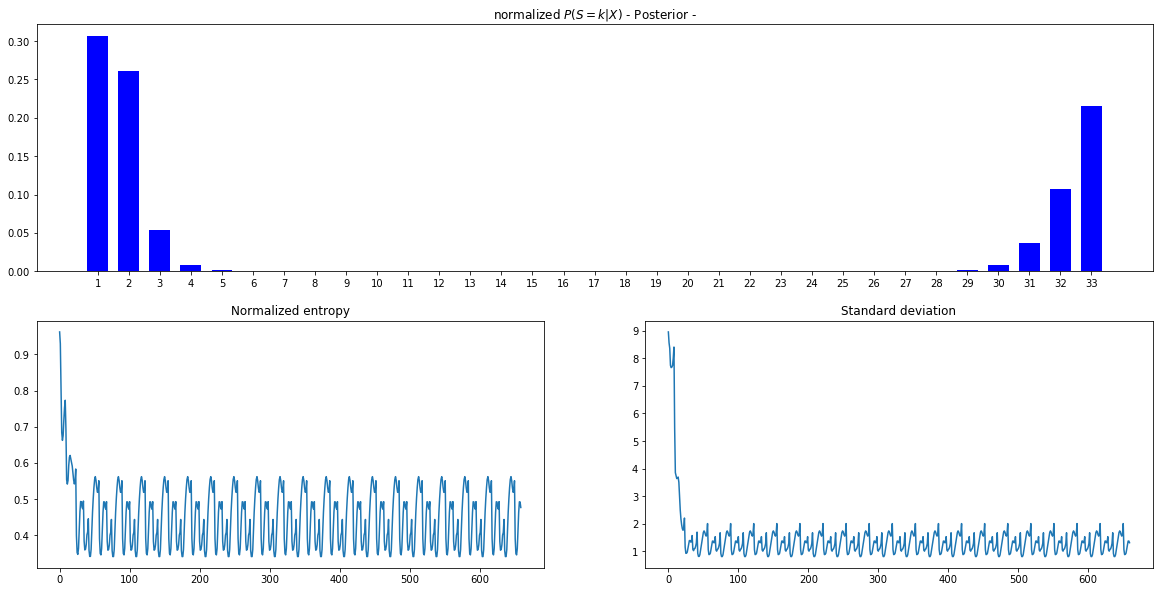

normalized entropy of last posterior: 0.476530977539


In [159]:
cicle = ['wall', 'wall', 'door', 'door', 'door', 'wall', 'wall', 'wall', 'wall', 'door', 'door', 
         'door', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 
         'wall', 'wall', 'door', 'door', 'door', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall',
         'wall', 'wall', 'door', 'door', 'door', 'wall', 'wall', 'wall', 'wall', 'door', 'door', 
         'door', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 
         'wall', 'wall', 'door', 'door', 'door', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall']
n_of_cicles = 10
n_cicles = []
for i in range(n_of_cicles):
    n_cicles = n_cicles + cicle

plot_histogram_entropy_std(n_cicles, transition, likelihood, prior, n_steps = len(n_cicles))

What is the remaining error oscillation?

The error while the robot walks. The transition probabilities

# The generative model

Lets get real and use the generative model to get the sample observations

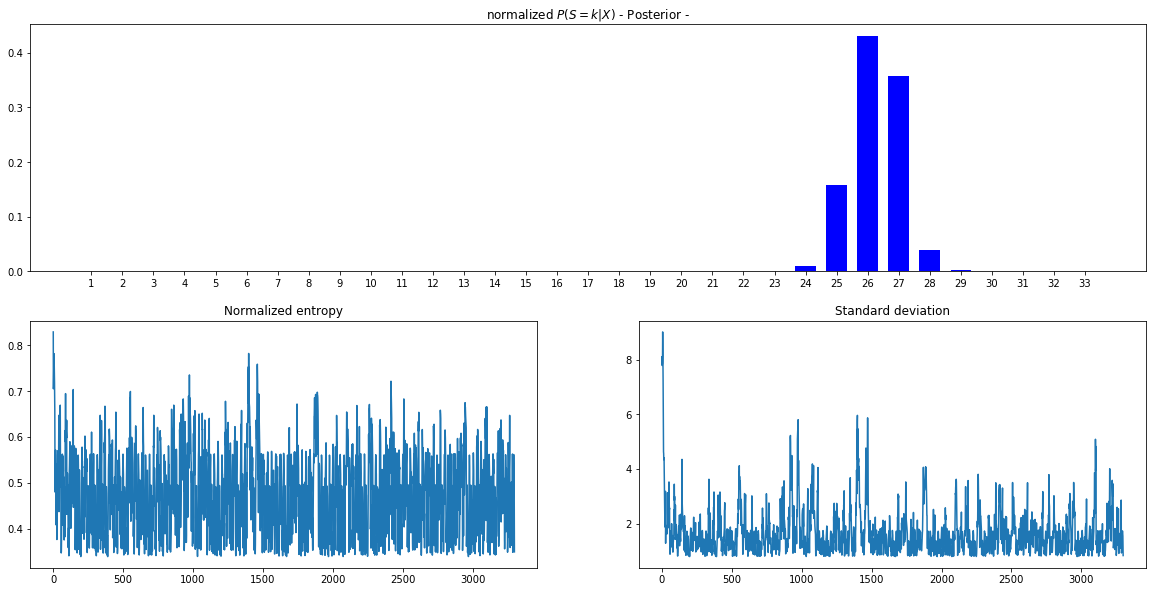

normalized entropy of last posterior: 0.349951111133


In [170]:
steps = 100*N
measurements, sample_stats, steps_stats, loc = generate_sample(likelihood_gen, transition, 
                                                               initial_state = 10,
                                                               steps = steps)
plot_histogram_entropy_std(measurements, transition, likelihood, prior, n_steps = len(measurements))

## No error while doing steps. Perfect walk!

In [69]:
steps = 2*N
transition_1 = np.array([0,1])
measurements, sample_stats, steps_stats, loc = generate_sample(likelihood_gen, transition_1, 
                                                               initial_state = 10,
                                                               steps = steps)

In [152]:
plot_interactive_histogram(measurements, transition_1, likelihood, prior, steps)

Why is the robot last position 9? Remember we are plotting the observation probability

Check the initial state to verify the answer

## What will happen if I have a perfect sensor but not perfect walk?

Two simple questions:

What would the observation error be?

What would the predicted histogram would be?


# References

S. Thrun, W. Burgard, and D. Fox. Probabilistic Robotics. MIT Press, Cambridge, MA, 2005.